### Module overview
Regarding particle data deposition onto grids in 2d or 3d, the `pgpy` package offers multiple `deposition` functions.\
The higher the order, the more adaptive (and the more costly) the deposition strategy becomes.

+ Cloud-in-Cell (cic): `cic_deposition()`
+ Adpative cic (adaptive cic): `cic_deposition()`
+ Isotropic Quintic Kernel: `isotropic_kernel_deposition()`
+ Anisotropic Quintic Kernel: `anisotropic_kernel_deposition()`

Generally, all strategies/functions share the following inputs:
- `positions`:   particle positions of shape (N, dim)
- `quantities`:  quantities can be stacked in the channels dimension, shape `(N, num_quantities)`
- `averaged`:    whether the quantity in a cell is averaged (e.g. temperature is averaged while mass is added), shape `(num_quantities,)`
- `extent`:      domain extent in simulation units, e.g. (0, boxsize), shape `(2,)`
- `gridnum`:     number of grid cells to use, same for each dimension, `int`
- `periodic`:    whether to account for periodic boundary conditions, `string`

In the following the `cic`, `adaptive cic`, `isotropic` and `anisotropic` strategies are theoretically described.

### Simple CIC
Simple cic spreads the particle quantity over the neighbouring overlapping cells. The particle "cloud" is a tophat kernel with the same compact support (i.e. size) as the grid cells.

### Adaptive CIC
One can adapt the tophat kernel size of each particle trough the argument `pcellsizesHalf` of shape `(N,)` of each particle.\
The tophat kernel will be adaptively changed according to these sizes like in the sample image below.\
**NN search**: Say we want to assign to `pcellsizesHalf` the distance to the **k**'th nearest neighbor of each particle. One can do so, by setting `num_nn`.

<img src="plots/cic_adaptive.png" width="300" height="300" align="left" />

### Isotropic kernel
For the isotropic kernel deposition, one can adopt a higher order sph-kernel (here a quintic kernel) that weighs the contribution between neighbouring cells.\
The kernel scaling size is typically defined as the smoothing length `h`, while the kernel compact support extends to `2h`.\
To compute the smoothing length, the code adopts a nearest neighbor search and assigns the smoothing length as the distance to the `nn`-th neighbor.\
This can be computed with the `compute_hsm(pos, nn, boxsize)` function from the `sph_modules` library.

`pos`= particle positions, `nn`= number of nearest neighbors, `boxsize`= boxsize of the periodic domain

### Anisotropic kernel
The next higher order is to allow the smoothing length to vary in different directions, i.e. instead of a smoothing length, the smoothing **tensor** $\text{H}$ is computed.\
Following (https://arxiv.org/abs/2106.08870) $\text{H}$ can be computed using the `compute_hsm_tensor(pos, masses, nn, boxsize)` function from the `sph_modules` library.\
It performs the following operations

+ the `nn` nearest neighbors are identified defining a cluster $C$

+ the clusters covariance tensor is computed
    $$\Sigma_C = M_C^{-1} \sum_C m_j (r_j -r_C) \otimes (r_j -r_C)$$
    
+ since $\text{H} = \Sigma_C^{1/2}$, compute the eigenvectors $(e_1, e_2, e_3)$ and -values $(h_1, h_2, h_3)$ of $\text{H}$

    + **3d**: the anisotropic kernel contributions are then computed as 
    $$W_H = (\det \text{H})^{-1} K(\xi_r)$$ with $$\xi_r =\sqrt{\xi_1^2+\xi_2^2+\xi_3^2}, \quad \xi_i = \frac{\mathbf{e}_j\cdot\mathbf{r}}{h_j}$$

    + **2d**: in the case of a 2d-projection, $\text{H}$ is first projected onto the specified plane via a projection matrix and \
        the eigenvectors and -values of $\text{H}_{2d}$ are used to evaulate the 2d kernel where $\xi_r =\sqrt{\xi_1^2+\xi_2^2}$ \
        To change the projection, the `plane` keyword can be set to either `xy`, `yz` or `xz`.

In [1]:
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

from sph_modules import (compute_hsm, 
                         compute_hsm_tensor)

from pgpy import (cic_deposition, 
                  isotropic_kernel_deposition, 
                  anisotropic_kernel_deposition)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
ds = pn.load('../../../../../shares/feldmann.ics.mnf.uzh/data/FIREbox/production_runs/FB15N128/snapshot_554.hdf5')


boxsize  = 15000
NN       = 32
periodic = True
gridnum  = 512
extent   = np.array([0, boxsize])

pos      = ds.gas['pos']
masses   = ds.gas['mass']
vx       = ds.gas['vel'][:, 0]
vy       = ds.gas['vel'][:, 1]
vz       = ds.gas['vel'][:, 2]
temp     = ds.gas['temp']
metals   = ds.gas['metals'][:, 0]


# IMPORTANT: hsm (tensor) needs to be computed from the 3d distribution (unless the simulation is 2d)!!
hsm = compute_hsm(pos, NN, boxsize)[0]
hmat, eλ, ev = compute_hsm_tensor(pos, masses, NN, boxsize)

# stack all quantities to deposit
quantities = np.stack([masses, vx, vy, vz, metals, temp], axis=-1); print(quantities.shape)

# dow we need to average the deposited quantities or not?
averaged   = [False, True, True, True, True, True]

/home/maurbe/data/conda/envs/wenv/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:555: RuntimeWarning: No unit information found in GadgetHDF file. Using gadget default units.
  warnings.warn("No unit information found in GadgetHDF file. Using gadget default units.", RuntimeWarning)
/home/maurbe/data/conda/envs/wenv/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:394: UserWarning: Unable to infer units from HDF attributes
  warnings.warn("Unable to infer units from HDF attributes")


(1949593, 6)


In [3]:
mask = np.logical_and(pos[:, -1] > 14000,
                      pos[:, -1] < 15000)

pos    = pos[mask]
masses = masses[mask]
hsm    = hsm[mask]
hmat   = hmat[mask]
quantities = quantities[mask]

pos = pos[:, :2]

kwargs = {'positions': pos, 
          'quantities': quantities, 
          'averaged': averaged, 
          'extent': extent, 
          'gridnum': gridnum, 
          'periodic': 1}

In [4]:

fields_cic, _ = cic_deposition(**kwargs)

fields_ada, _ = cic_deposition(**kwargs, num_nn=NN)

fields_iso, _ = isotropic_kernel_deposition(**kwargs, hsm=hsm)

fields_ani, _, eλ_2d, ev_2d = anisotropic_kernel_deposition(**kwargs, hmat=hmat, plane='xy', return_evals=True)


100%|██████████| 153687/153687 [08:29<00:00, 301.89it/s] 


We can plot the smoothing ellipses (projected 3d-ellipsoids to the plane) compared to the isotropic smoothing lengths (circles)

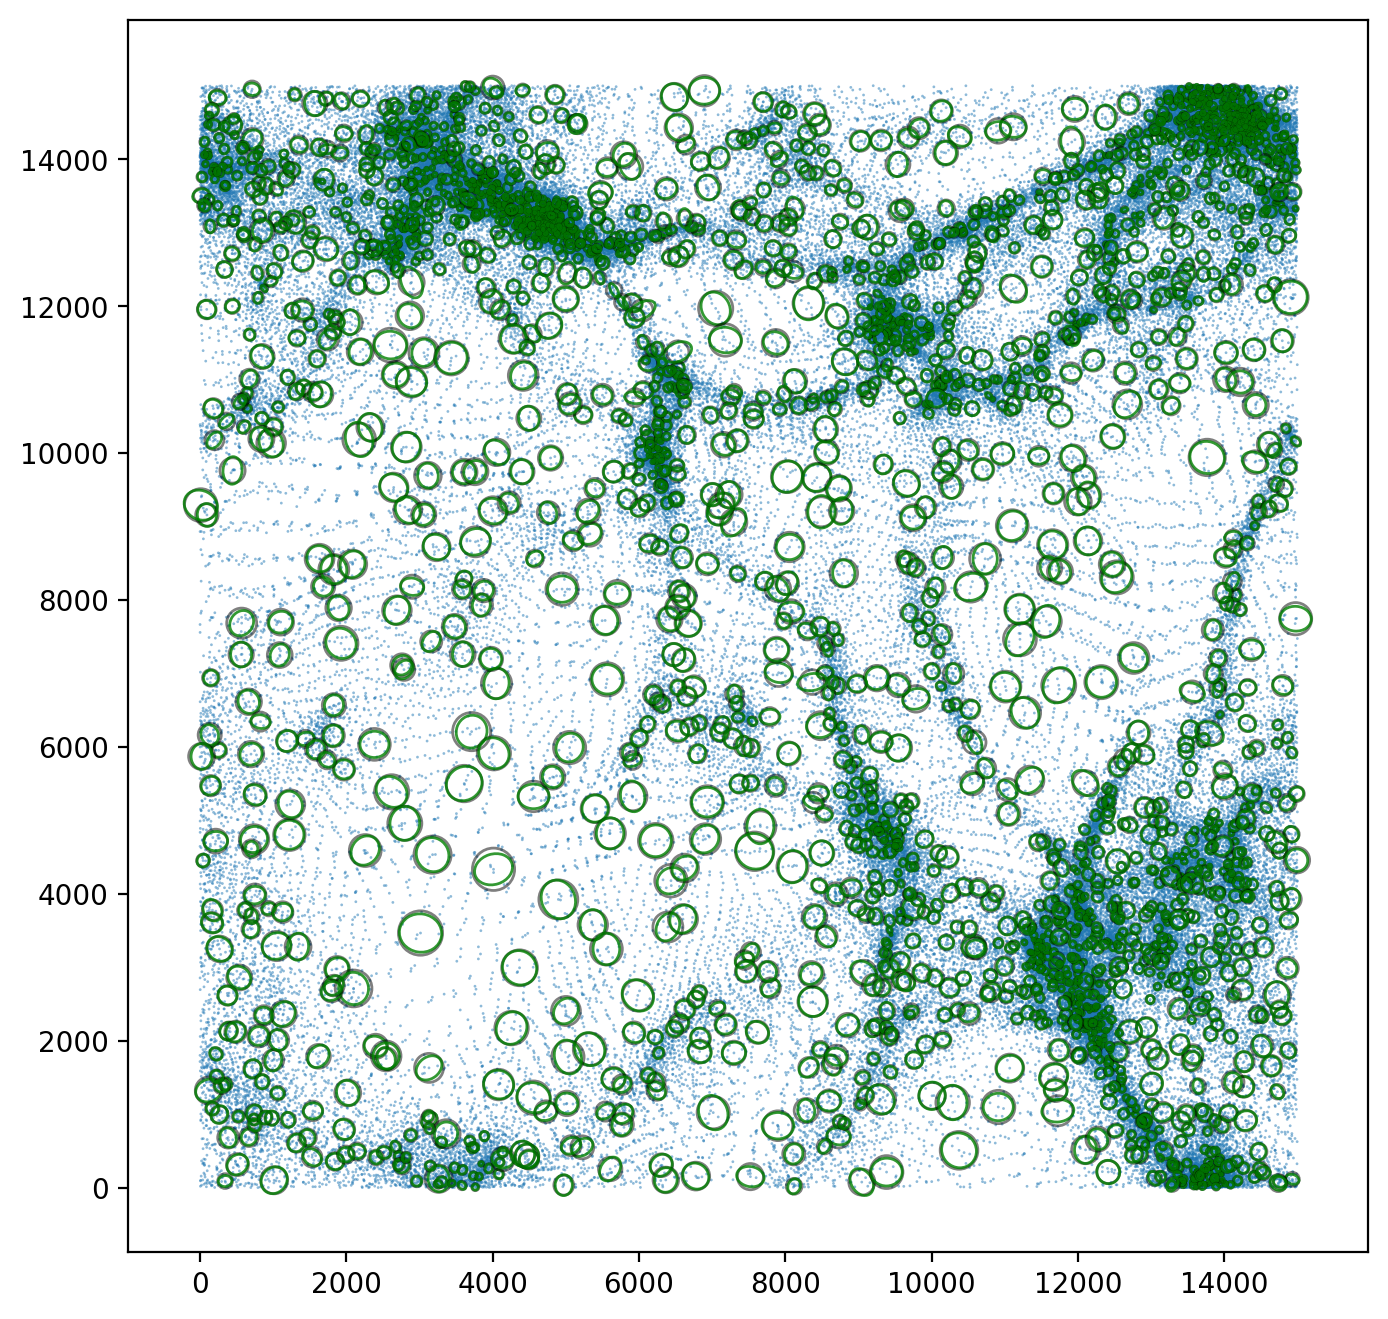

In [5]:
from matplotlib.patches import Circle, Ellipse

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pos[:, 0], pos[:, 1], s=1, ec='none', alpha=0.5)

def draw_circle(ax, center, radius):
    circle = Circle(center, radius, 
                    fill=False, edgecolor='k', lw=1, alpha=0.5)
    ax.add_patch(circle)

def draw_ellipse(ax, center, width, height, angle):
    ellipse = Ellipse(center, width, height, angle=angle, 
                      fill=False, edgecolor='g', lw=1, alpha=0.8)
    ax.add_patch(ellipse)


for p, h, w, v in zip(pos[::50], 
                      hsm[::50], 
                      eλ_2d[::50], 
                      ev_2d[::50]):

    # Calculate width, height, and angle of the ellipse
    width, height = 2*w
    angle = np.degrees(np.arctan2(*v[:, 0][::-1]))

    # Draw the smoothing circle and ellipse
    center = (p[0], p[1])
    draw_circle(ax, center, h)
    draw_ellipse(ax, center, width, height, angle)
    

In [6]:
fields = [fields_cic,
          fields_ada, 
          fields_iso,
          fields_ani]

/sctmp/maurbe/ipykernel_2454676/3583428643.py:6: RuntimeWarning: divide by zero encountered in log10
  ax[j, 0].imshow(np.log10(fields[j][fov][...,0]), cmap='bone', vmin=-5)
/sctmp/maurbe/ipykernel_2454676/3583428643.py:8: RuntimeWarning: divide by zero encountered in log10
  ax[j, 2].imshow(np.log10(fields[j][fov][...,-2]), cmap='binary_r')
/sctmp/maurbe/ipykernel_2454676/3583428643.py:9: RuntimeWarning: divide by zero encountered in log10
  ax[j, 3].imshow(np.log10(fields[j][fov][...,-1]), cmap='gist_heat')


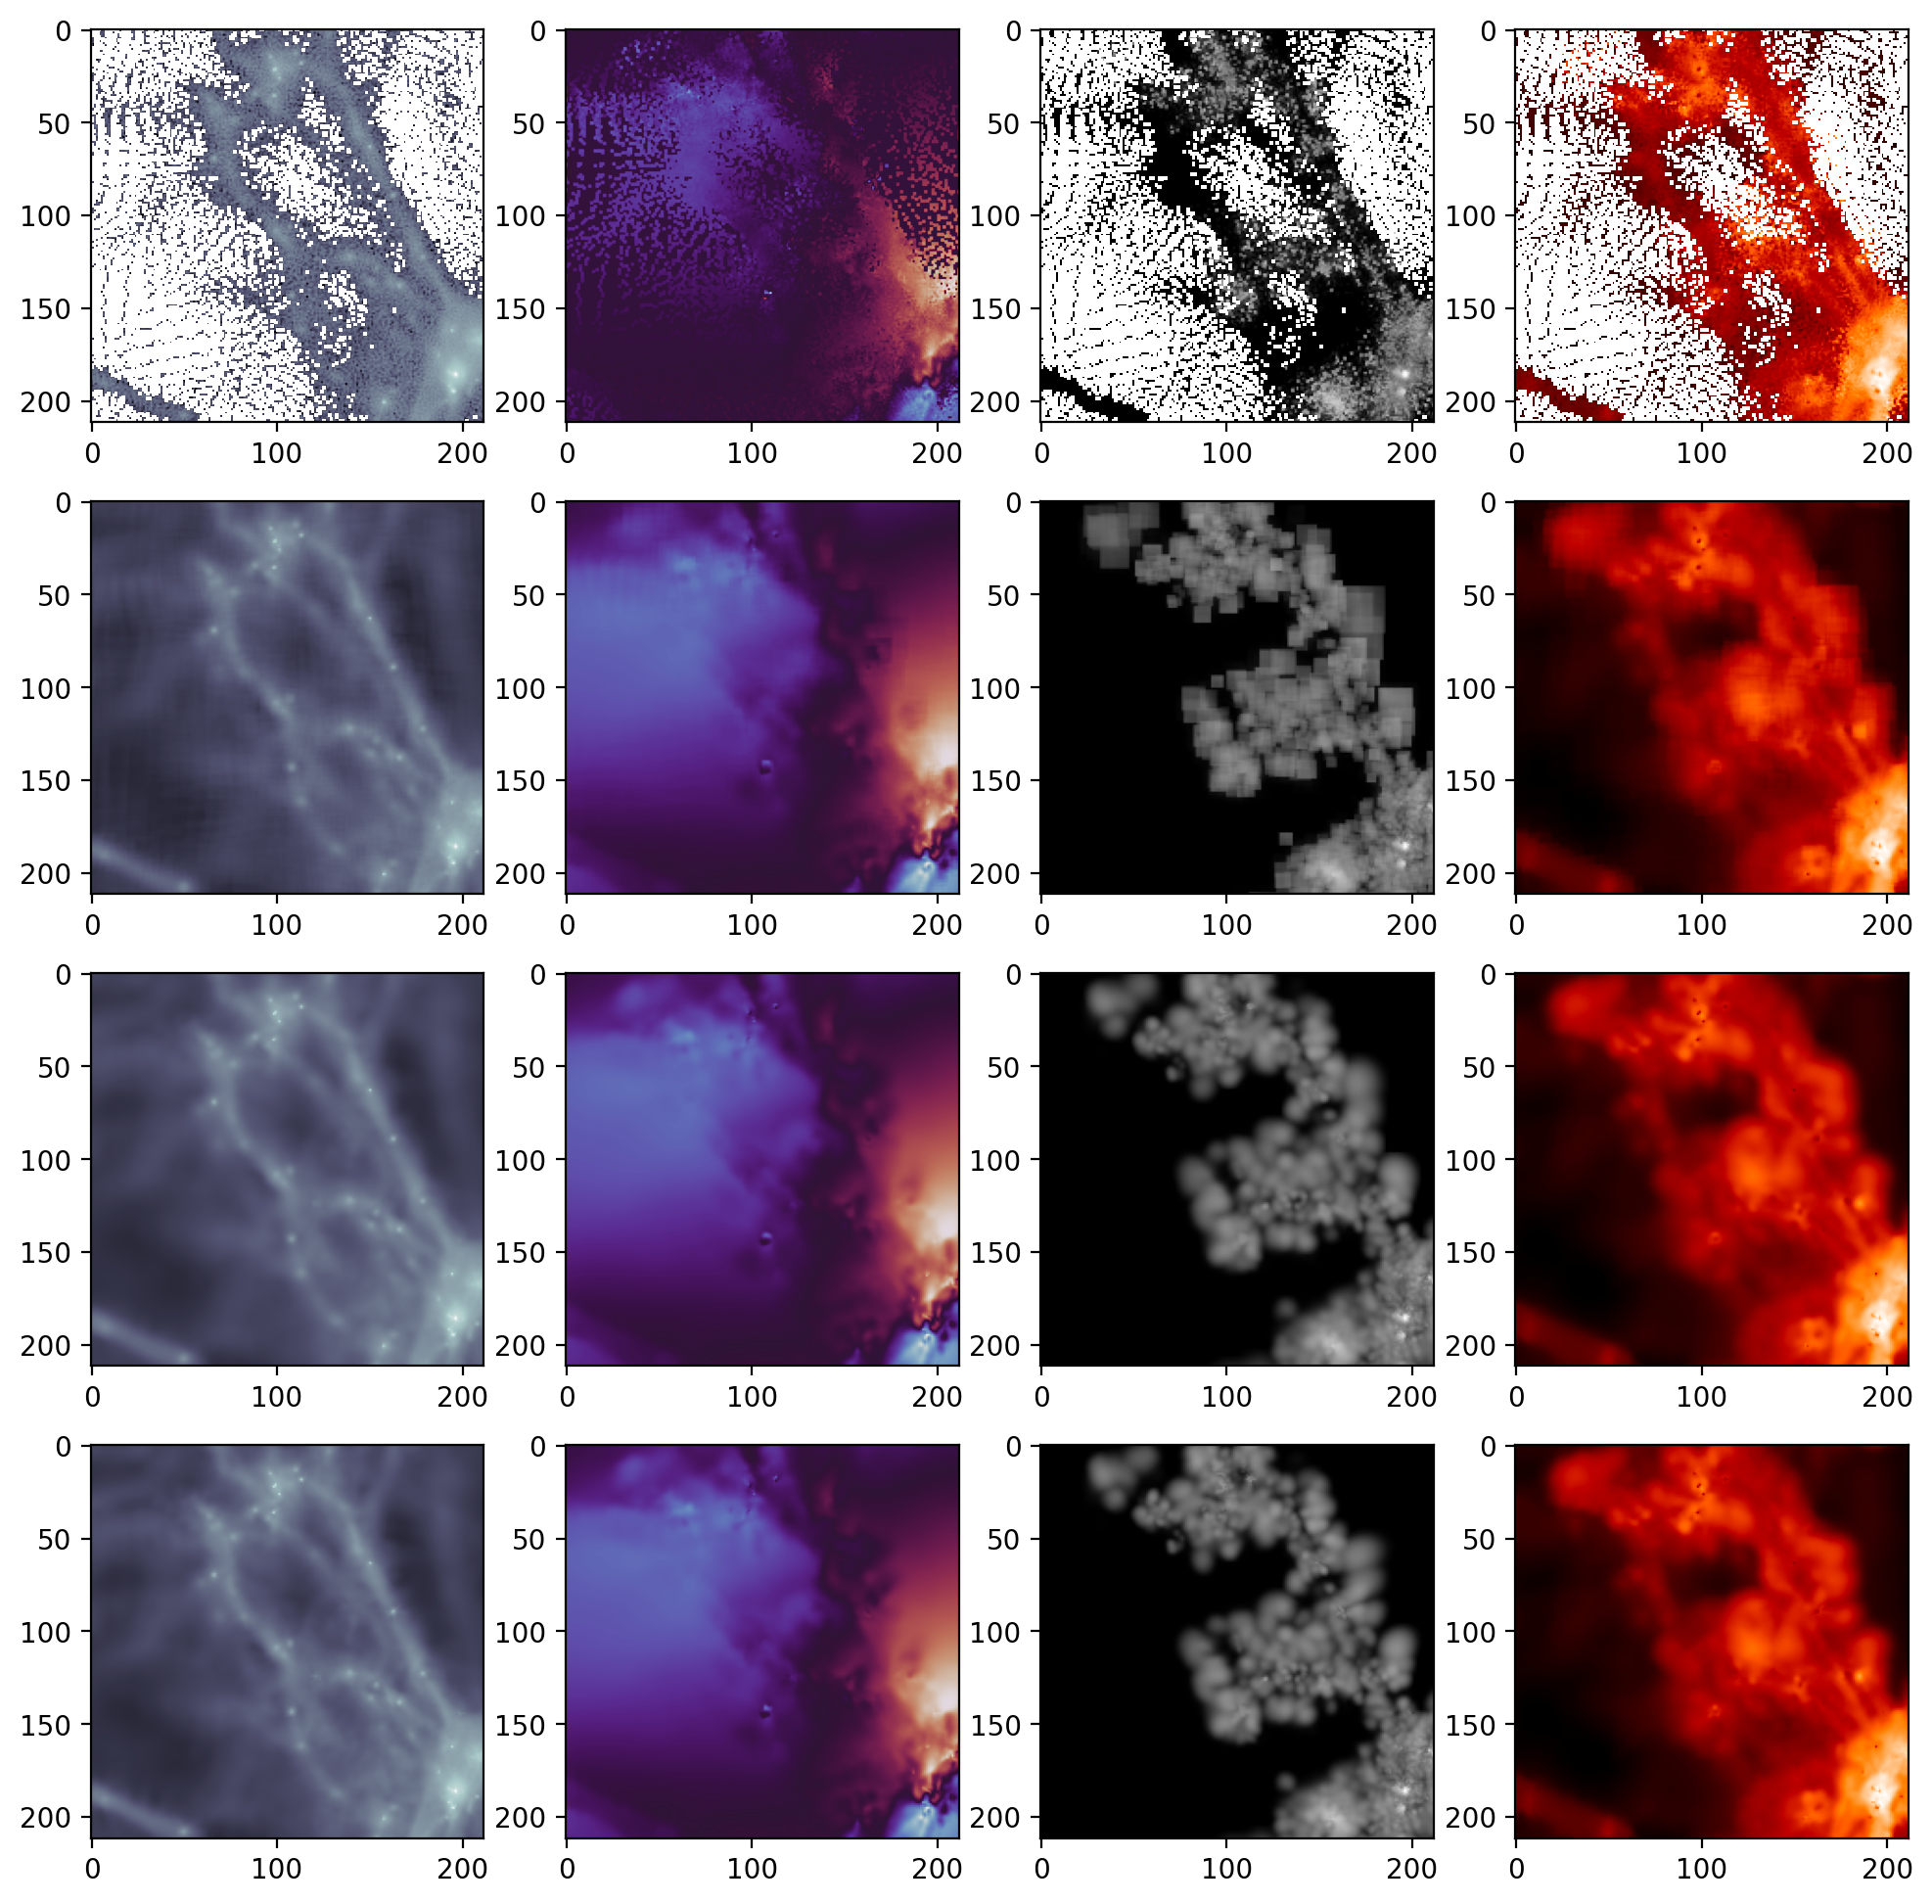

In [7]:
fig, ax = plt.subplots(4, 4, figsize=(12, 12))

for j in range(4):
    fov = np.s_[300:, 300:] #300, 300:]

    ax[j, 0].imshow(np.log10(fields[j][fov][...,0]), cmap='bone', vmin=-5)
    ax[j, 1].imshow(fields[j][fov][...,1], cmap='twilight')
    ax[j, 2].imshow(np.log10(fields[j][fov][...,-2]), cmap='binary_r')
    ax[j, 3].imshow(np.log10(fields[j][fov][...,-1]), cmap='gist_heat')

    #for a in ax.flat:
    #    a.axis('off')

fig.savefig('plots/deposition_comparison.png', transparent=True, dpi=300)
plt.show()